# Novosparc

To-do: 

1. Clean up notebook, run separately for both together, ctcf alone, control alone
2. Limit marker genes to those in my hvg subset
3. Possibly re-run scvi on all genes and do everything without subsetting

In [1]:
# Setup
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import altair as alt
from color_tol import qualitative
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

In [2]:
my_map = qualitative(10)

In [3]:
my_colors = ListedColormap(my_map.html_colors[:8])

In [4]:
# Load adata
adata = anndata.read_h5ad("/Volumes/Mac-External/insulator/results/insulator_withoutcp190_mito5_multimap_6000hvg_070521.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 8281 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [6]:
adata.X = adata.layers['scvi_norm_log']

In [7]:
adata = adata[adata.obs.leiden_scVI != ("8" and "9")]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 7975 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [23]:
# this is from a novosparc pull request not implemented yet 

def quantify_clusters_spatially(tissue):
    """Maps the annotated clusters obtained from the scRNA-seq analysis onto
    the tissue space.
    Args:
        tissue: the novosparc tissue object containing the gene expression data,
                the clusters annotation and the spatial reconstruction. Assumes
                that the cluster annotation exists in the underlying anndata object.
    Returns:
        [numpy array]: An array of the cluster annotation per tissue position.
    """
    clusters = tissue.dataset.obs['leiden_scVI'].to_numpy().flatten()
    return np.array([np.argmax(np.array([np.median(np.array(tissue.gw[:, location][np.argwhere(clusters == cluster).flatten()]))
                                         for cluster in np.unique(clusters)])) for location in range(len(tissue.locations))])


In [9]:
adata.obs.leiden_scVI.unique()

['4', '1', '8', '6', '2', '0', '3', '5', '7']
Categories (9, object): ['4', '1', '8', '6', ..., '0', '3', '5', '7']

In [10]:
atlas_dir = '/Users/aralbright/repositories/novosparc/novosparc/datasets/bdtnp'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

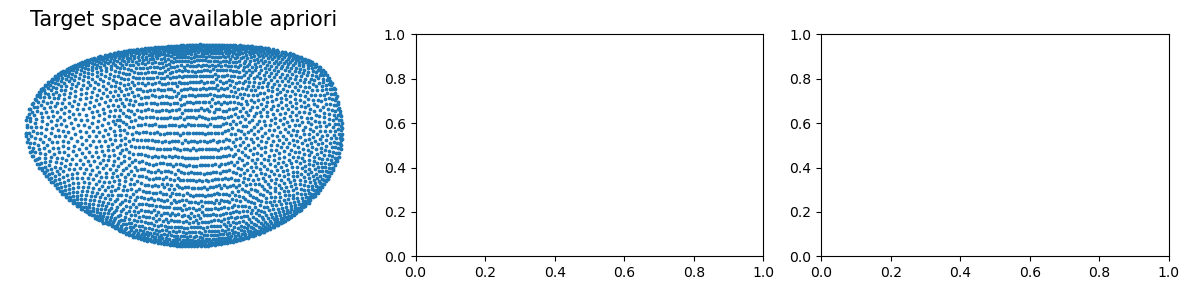

In [11]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=dpi)

ax[0].scatter(locations_apriori[:, 0], locations_apriori[:, 1], s=3)

ax[0].set_title('Target space available apriori', size=tit_size)


ax[0].axis('off')


plt.tight_layout()
plt.show()

In [12]:
pl_genes = ['Antp', 'Dfd', 'ftz']

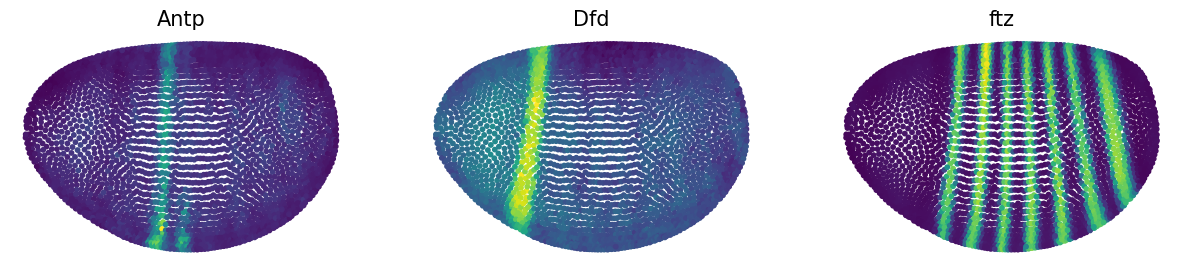

<Figure size 432x288 with 0 Axes>

In [13]:
locations = locations_apriori
atlas_dir = '/Users/aralbright/repositories/novosparc/novosparc/datasets/bdtnp'
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

novosparc.pl.embedding(atlas, pl_genes)

## all nuclei

In [14]:
adata

View of AnnData object with n_obs × n_vars = 7975 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [15]:
dataset = adata

In [16]:
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)


number of cells: 7975
number of genes: 5999


In [17]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [18]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(adata.var.gene))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)


In [19]:

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 625.69 seconds )


In [20]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 65 markers: 7975 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


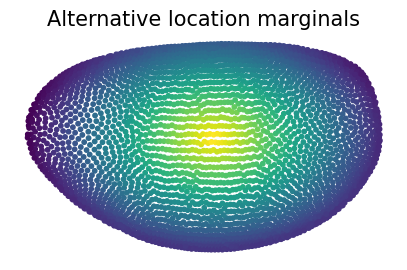

<Figure size 432x288 with 0 Axes>

In [21]:
# configure locations probability values
rdist = novosparc.gm.prob_dist_from_center(locations)
atlas.obs['Alternative location marginals'] = rdist

novosparc.pl.embedding(atlas, ['Alternative location marginals'])
# tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon, p_locations=rdist)

In [24]:
leiden_location = quantify_clusters_spatially(tissue)

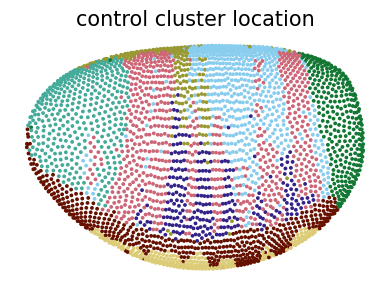

In [25]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], c=leiden_location, cmap = my_colors, s=3)

ax.set_title('control cluster location', size=tit_size)


ax.axis('off')



plt.tight_layout()
plt.show()

In [ ]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes, title=title)

In [27]:
dataset_reconst.obs.index = dataset_reconst.obs.index.map(str)

In [28]:
dataset_reconst.obs = pd.merge(pd.DataFrame(dataset_reconst.obs), df, on = dataset_reconst.obs.index)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [29]:
dataset_reconst.obs

key_0  archetype 0  archetype 1  archetype 2  archetype 3  archetype 4  \
0        0     0.002213     0.001317     0.002431     0.005155     0.001283   
1        1     0.002422     0.001287     0.001674     0.011033     0.000691   
2        2     0.002791     0.001212     0.002156     0.006988     0.001086   
3        3     0.002397     0.001301     0.001598     0.011338     0.000618   
4        4     0.001966     0.001436     0.002014     0.007786     0.000915   
...    ...          ...          ...          ...          ...          ...   
3034  3034     0.000626     0.000858     0.003040     0.001583     0.010691   
3035  3035     0.011537     0.001395     0.002555     0.001725     0.001768   
3036  3036     0.001200     0.001099     0.002463     0.007694     0.001388   
3037  3037     0.000343     0.000951     0.002506     0.006545     0.001620   
3038  3038     0.000764     0.000685     0.006328     0.001388     0.004814   

      archetype 5  archetype 6  archetype 7  archetype 8  archetype 9  
0        0.011979     0.005463     0.023860     0.026035     0.005949  
1        0.008800     0.005523     0.057083     0.022191     0.011387  
2        0.009846     0.005375     0.033048     0.024466     0.009444  
3        0.008623     0.005824     0.062580     0.021871     0.011749  
4        0.012392     0.005375     0.035136     0.025940     0.005922  
...           ...          ...          ...          ...          ...  
3034     0.009315     0.001665     0.002947     0.021654     0.007465  
3035     0.007117     0.001959     0.002175     0.027474     0.006288  
3036     0.007316     0.004948     0.028829     0.019570     0.035345  
3037     0.007313     0.000698     0.005278     0.019675     0.102969  
3038     0.011221     0.001302     0.002323     0.039503     0.004647  

[3039 rows x 11 columns]

Finding gene archetypes ... done


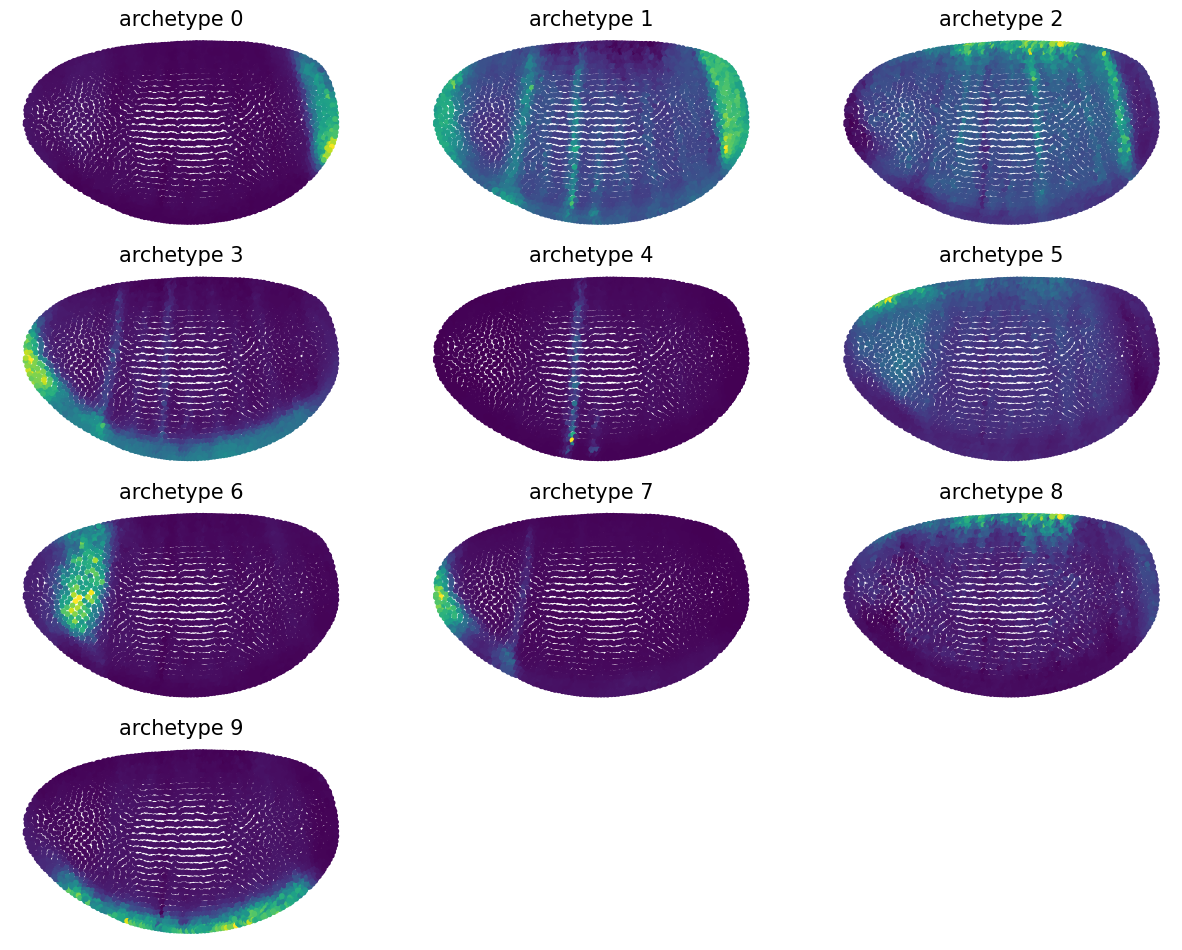

<Figure size 432x288 with 0 Axes>

In [30]:
# plot spatial expression archetypes
num_clusters = 10
atlas_indices = pd.DataFrame(np.arange(num_genes), index=gene_names)[0].loc[markers].values
archetypes, clusters, gene_corrs = novosparc.rc.find_spatial_archetypes(num_clusters, sdge[atlas_indices,:])

arch_cols = ['archetype %d'% i for i in np.arange(num_clusters)]
#dataset_reconst.obs = pd.DataFrame(index=dataset_reconst.obs.index)
df = pd.DataFrame(archetypes.T, columns=arch_cols)
#dataset_reconst.obs = pd.concat((dataset_reconst.obs, df), 1)

novosparc.pl.embedding(dataset_reconst, arch_cols)

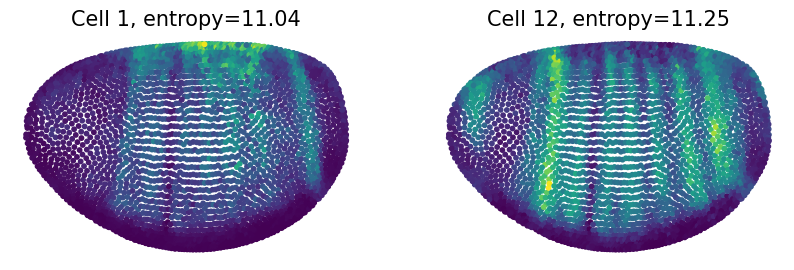

<Figure size 432x288 with 0 Axes>

In [31]:

# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = [1, 12]
cell_prb_cols = ['cell %d' % i for i in cell_idx]
dataset_reconst.obs = pd.DataFrame(ngw.T[:, cell_idx], columns=cell_prb_cols)

title=['Cell %d, entropy=%.02f' % (i, novosparc.an.get_cell_entropy(ngw[i,:])) for i in cell_idx]
novosparc.pl.embedding(dataset_reconst, cell_prb_cols, title=title)

Reconstructing spatial information with 65 markers: 8281 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


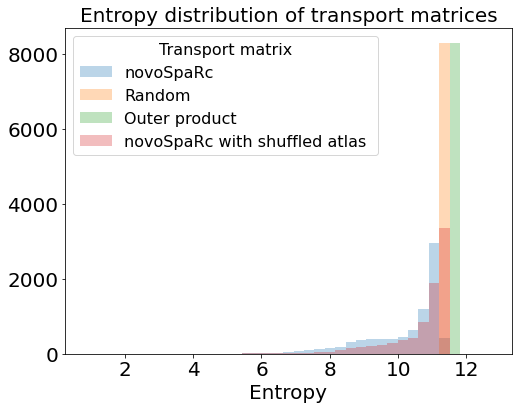

KstestResult(statistic=0.9939620818741698, pvalue=0.0)
KstestResult(statistic=0.3590146117618645, pvalue=0.0)


In [32]:

# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))

In [30]:

# Looking for spatially informative genes according to reconstruction in highly variable genes

cyc_genes = [g for g in gene_names if g.startswith('Cyc')]
atlas_genes = list(adata.var_names)
mI_genes = cyc_genes + atlas_genes

tissue.calculate_spatially_informative_genes(mI_genes)
genes_with_scores = tissue.spatially_informative_genes

genes_with_scores.index = genes_with_scores['genes']

gene_groups = {'Atlas': atlas_genes, 'Cell-cycle': cyc_genes}
novosparc.pl.plot_morans_dists(genes_with_scores, gene_groups)

gene_max_mI = genes_with_scores['genes'].iloc[0]
gene_min_mI = genes_with_scores['genes'].iloc[-1]

title = ['%s, Morans`I=%.02f' % (gene_max_mI, genes_with_scores.loc[gene_max_mI]['mI']), 
         '%s, Morans`I=%.02f' % (gene_min_mI, genes_with_scores.loc[gene_min_mI]['mI'])]

novosparc.pl.embedding(dataset_reconst, [gene_max_mI, gene_min_mI], title=title)

print('Mean Morans I for cell-cycle genes: %.02f' % genes_with_scores.loc[cyc_genes]['mI'].mean())
print('Mean Morans I for atlas genes: %.02f' % genes_with_scores.loc[atlas_genes]['mI'].mean())

Morans I analysis for 5999 genes...

KeyboardInterrupt: 

## adata[adata.obs.batch =="0"]

In [15]:
adata[adata.obs.batch =="0"]

View of AnnData object with n_obs × n_vars = 3718 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [112]:
dataset = adata[adata.obs.batch == '0']

In [113]:
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)


number of cells: 3718
number of genes: 5999


In [114]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [115]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(adata.var.gene))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 129.54 seconds )


In [116]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 65 markers: 3718 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


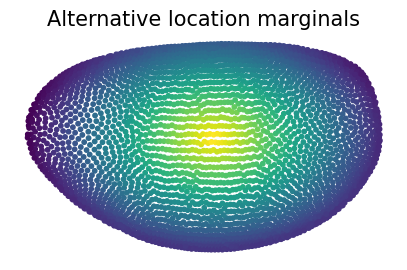

<Figure size 432x288 with 0 Axes>

In [117]:
# configure locations probability values
rdist = novosparc.gm.prob_dist_from_center(locations)
atlas.obs['Alternative location marginals'] = rdist

novosparc.pl.embedding(atlas, ['Alternative location marginals'])
# tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon, p_locations=rdist)

In [118]:
tissue.dataset.obs

cell_counts  n_genes  percent_mito     n_counts batch  \
index                                                                       
AAACCCAGTGCCTACG-0       5174.0     1584      0.904523  5150.200195     0   
AAACCCATCATTTCGT-0       3211.0     1173      0.747431  3198.000000     0   
AAACGAAAGTAGCTCT-0       2075.0      844      1.204819  2070.000000     0   
AAACGAAAGTTGCTCA-0       7307.0     1920      0.889558  7278.000000     0   
AAACGAACAACTACGT-0       6034.0     1643      1.118661  5993.500000     0   
...                         ...      ...           ...          ...   ...   
TTTGGTTCAAAGCTCT-0       2857.0     1159      1.242562  2844.500000     0   
TTTGGTTTCTAGTTCT-0       3436.0     1216      0.669383  3428.000000     0   
TTTGTTGCACAAATAG-0       3710.0     1390      0.835580  3698.000000     0   
TTTGTTGGTGACTAAA-0       2454.0     1002      0.733496  2450.000000     0   
TTTGTTGTCGCCAGTG-0       4259.0     1392      0.457854  4250.500000     0   

                    _scvi_batch  _scvi_labels  _scvi_local_l_mean  \
index                                                               
AAACCCAGTGCCTACG-0            0             0            7.111671   
AAACCCATCATTTCGT-0            0             0            7.111671   
AAACGAAAGTAGCTCT-0            0             0            7.111671   
AAACGAAAGTTGCTCA-0            0             0            7.111671   
AAACGAACAACTACGT-0            0             0            7.111671   
...                         ...           ...                 ...   
TTTGGTTCAAAGCTCT-0            0             0            7.111671   
TTTGGTTTCTAGTTCT-0            0             0            7.111671   
TTTGTTGCACAAATAG-0            0             0            7.111671   
TTTGTTGGTGACTAAA-0            0             0            7.111671   
TTTGTTGTCGCCAGTG-0            0             0            7.111671   

                    _scvi_local_l_var leiden_scVI  
index                                              
AAACCCAGTGCCTACG-0           0.691146           4  
AAACCCATCATTTCGT-0           0.691146           1  
AAACGAAAGTAGCTCT-0           0.691146           6  
AAACGAAAGTTGCTCA-0           0.691146           1  
AAACGAACAACTACGT-0           0.691146           2  
...                               ...         ...  
TTTGGTTCAAAGCTCT-0           0.691146           1  
TTTGGTTTCTAGTTCT-0           0.691146           5  
TTTGTTGCACAAATAG-0           0.691146           5  
TTTGTTGGTGACTAAA-0           0.691146           2  
TTTGTTGTCGCCAGTG-0           0.691146           4  

[3718 rows x 10 columns]

In [121]:
leiden_location = quantify_clusters_spatially(tissue)

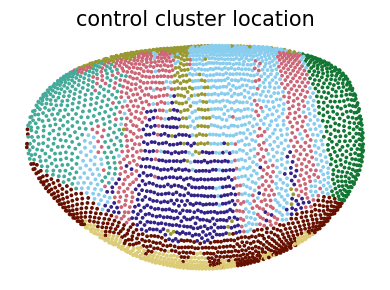

In [122]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], c=leiden_location, cmap = my_colors, s=3)

ax.set_title('control cluster location', size=tit_size)


ax.axis('off')



plt.tight_layout()
plt.show()

In [26]:
pl_genes = ['bowl', 'oc', 'mnd','Esp', 'net', 'Atet', 'stumps', 'Mes2']

/Users/aralbright/opt/anaconda3/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


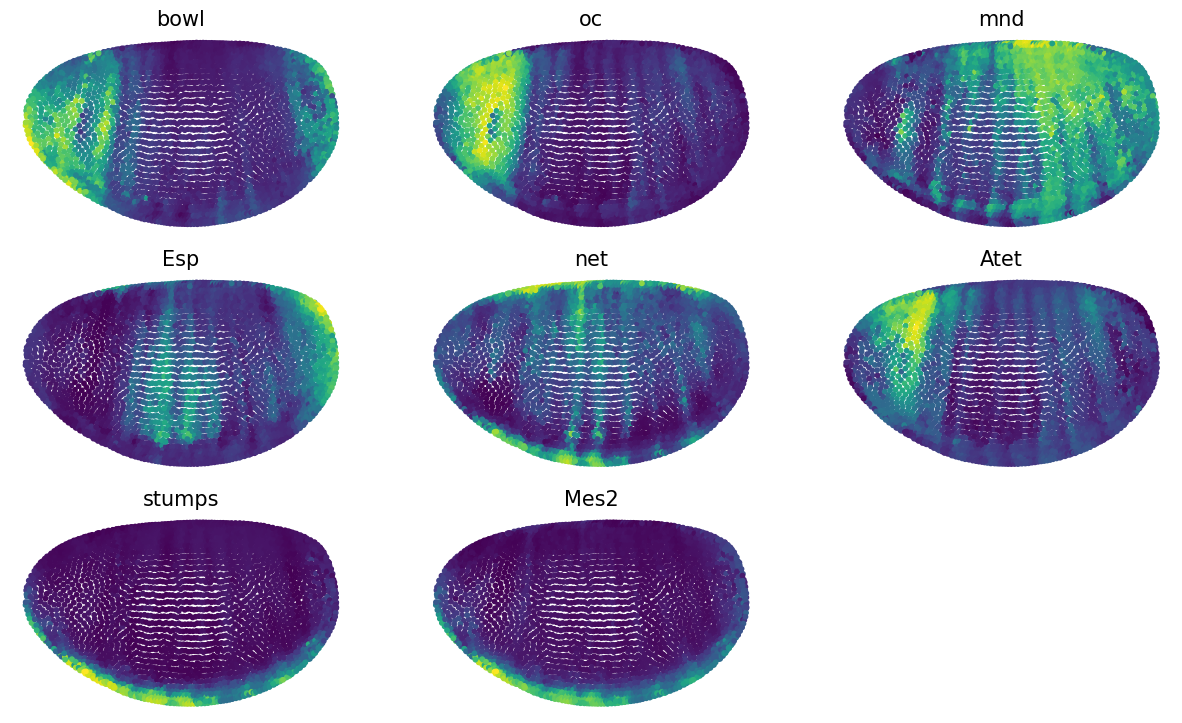

<Figure size 432x288 with 0 Axes>

In [27]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

#title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]

novosparc.pl.embedding(dataset_reconst, pl_genes)
#novosparc.pl.embedding(dataset_reconst, leiden_location)

In [35]:
pl_genes = ['Antp', 'ftz', 'Dfd']

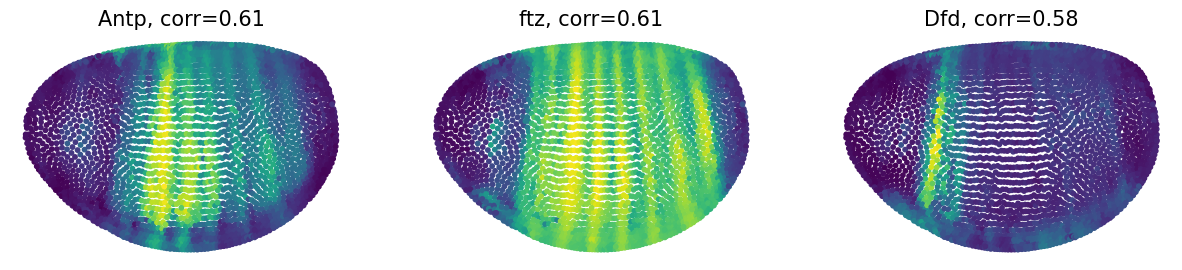

<Figure size 432x288 with 0 Axes>

In [36]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]

novosparc.pl.embedding(dataset_reconst, pl_genes, title = title)

Finding gene archetypes ... 

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


done


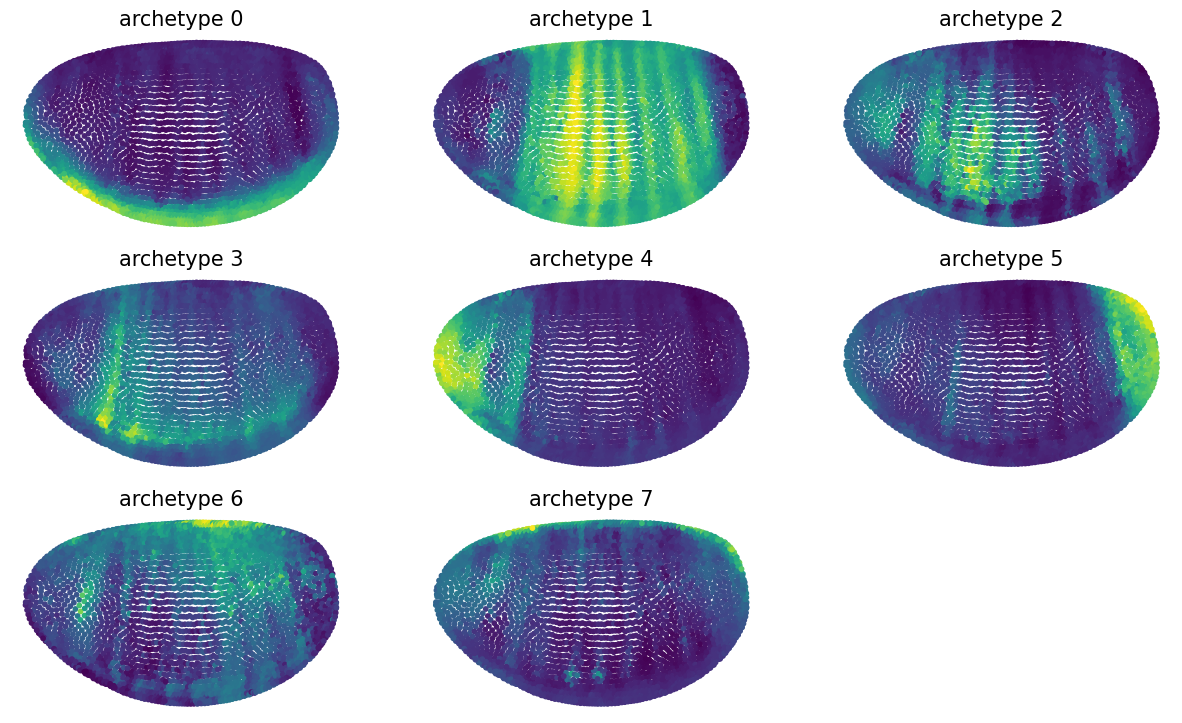

<Figure size 432x288 with 0 Axes>

In [37]:
# plot spatial expression archtypes
num_clusters = 8
atlas_indices = pd.DataFrame(np.arange(num_genes), index=gene_names)[0].loc[markers].values
archetypes, clusters, gene_corrs = novosparc.rc.find_spatial_archetypes(num_clusters, sdge[atlas_indices,:])

arch_cols = ['archetype %d'% i for i in np.arange(num_clusters)]
#dataset_reconst.obs = pd.DataFrame(index=dataset_reconst.obs.index)
df = pd.DataFrame(archetypes.T, columns=arch_cols)
#dataset_reconst.obs = pd.concat((dataset_reconst.obs, df), 1)

dataset_reconst.obs.index = dataset_reconst.obs.index.map(str)
dataset_reconst.obs = pd.merge(pd.DataFrame(dataset_reconst.obs), df, on = dataset_reconst.obs.index)

novosparc.pl.embedding(dataset_reconst, arch_cols)

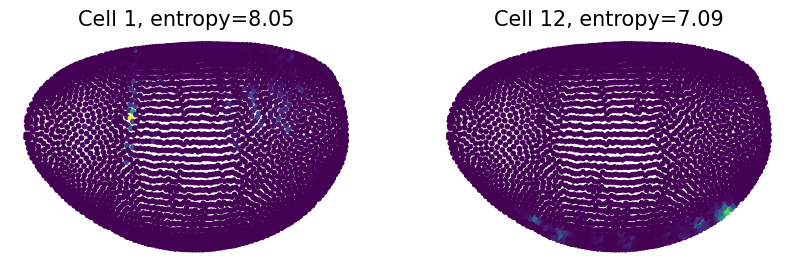

<Figure size 432x288 with 0 Axes>

In [29]:
# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = [1, 12]
cell_prb_cols = ['cell %d' % i for i in cell_idx]
dataset_reconst.obs = pd.DataFrame(ngw.T[:, cell_idx], columns=cell_prb_cols)

title=['Cell %d, entropy=%.02f' % (i, novosparc.an.get_cell_entropy(ngw[i,:])) for i in cell_idx]
novosparc.pl.embedding(dataset_reconst, cell_prb_cols, title=title)

Reconstructing spatial information with 65 markers: 3718 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


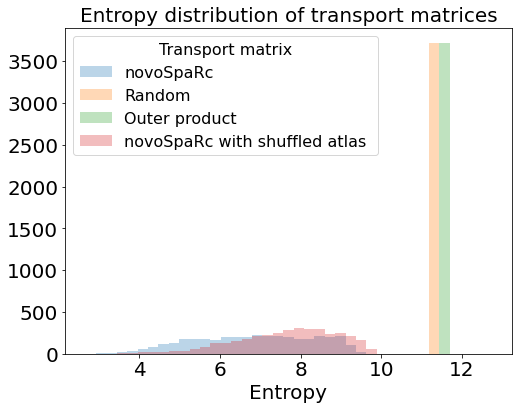

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=0.23587950511027433, pvalue=4.1718646556208404e-91)


In [30]:
# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))

## adata[adata.obs.batch =="1"]

In [99]:
dataset = adata[adata.obs.batch == '1']

In [100]:
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)


number of cells: 3827
number of genes: 5999


In [101]:
adata.obs

cell_counts  n_genes  percent_mito     n_counts batch  \
index                                                                       
AAACCCAGTGCCTACG-0  5174.000000     1584      0.904523  5150.200195     0   
AAACCCATCATTTCGT-0  3211.000000     1173      0.747431  3198.000000     0   
AAACGAAAGTAGCTCT-0  2075.000000      844      1.204819  2070.000000     0   
AAACGAAAGTTGCTCA-0  7307.000000     1920      0.889558  7278.000000     0   
AAACGAACAACTACGT-0  6034.000000     1643      1.118661  5993.500000     0   
...                         ...      ...           ...          ...   ...   
TTTGGTTTCTTTCCGG-1  9068.999023     2350      1.043849  9025.332031     1   
TTTGTTGCAAAGACGC-1  6264.000977     1964      2.322797  6223.500488     1   
TTTGTTGCATACAGGG-1  6723.000000     1924      1.234568  6699.000000     1   
TTTGTTGGTGCTTCAA-1  4998.000977     1581      1.800720  4951.000977     1   
TTTGTTGTCTACGCAA-1  3154.000000     1104      1.680406  3142.000000     1   

                    _scvi_batch  _scvi_labels  _scvi_local_l_mean  \
index                                                               
AAACCCAGTGCCTACG-0            0             0            7.111671   
AAACCCATCATTTCGT-0            0             0            7.111671   
AAACGAAAGTAGCTCT-0            0             0            7.111671   
AAACGAAAGTTGCTCA-0            0             0            7.111671   
AAACGAACAACTACGT-0            0             0            7.111671   
...                         ...           ...                 ...   
TTTGGTTTCTTTCCGG-1            1             0            7.673533   
TTTGTTGCAAAGACGC-1            1             0            7.673533   
TTTGTTGCATACAGGG-1            1             0            7.673533   
TTTGTTGGTGCTTCAA-1            1             0            7.673533   
TTTGTTGTCTACGCAA-1            1             0            7.673533   

                    _scvi_local_l_var leiden_scVI  
index                                              
AAACCCAGTGCCTACG-0           0.691146           4  
AAACCCATCATTTCGT-0           0.691146           1  
AAACGAAAGTAGCTCT-0           0.691146           6  
AAACGAAAGTTGCTCA-0           0.691146           1  
AAACGAACAACTACGT-0           0.691146           2  
...                               ...         ...  
TTTGGTTTCTTTCCGG-1           0.509960           4  
TTTGTTGCAAAGACGC-1           0.509960           0  
TTTGTTGCATACAGGG-1           0.509960           0  
TTTGTTGGTGCTTCAA-1           0.509960           4  
TTTGTTGTCTACGCAA-1           0.509960           6  

[7545 rows x 10 columns]

In [102]:
atlas_dir = '/Users/aralbright/repositories/novosparc/novosparc/datasets/bdtnp'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

In [103]:
#pl_genes = ['ftz', 'h', 'odd', 'eve']

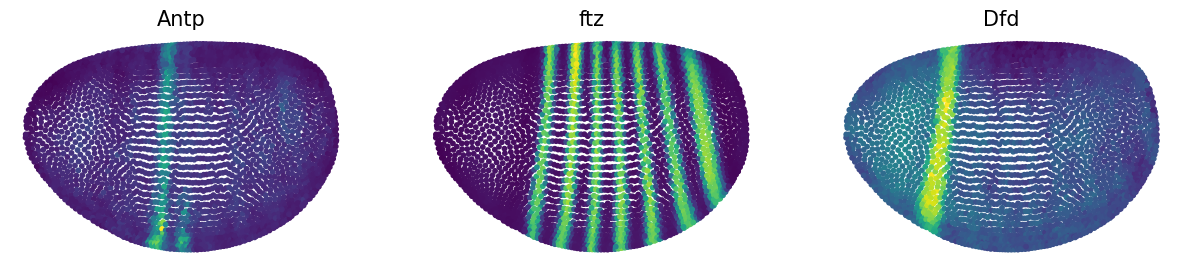

<Figure size 432x288 with 0 Axes>

In [104]:
locations = locations_apriori
atlas_dir = '/Users/aralbright/repositories/novosparc/novosparc/datasets/bdtnp'
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

novosparc.pl.embedding(atlas, pl_genes)

In [105]:
# Tip: visualizing loc-loc expression distances vs their physical distances
#novosparc.pl.plot_exp_loc_dists(adata.X, locations)

In [106]:
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations)

In [107]:
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(adata.var.gene))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# alternative 1: setup both assumptions 
tissue.setup_reconstruction(atlas_matrix=atlas_matrix, 
                            markers_to_use=markers_to_use, 
                            num_neighbors_s=num_neighbors_s, 
                            num_neighbors_t=num_neighbors_t)

# alternative 2: handling each assumption separately
#tissue.setup_smooth_costs(dge_rep=dge_rep)
#tissue.setup_linear_cost(markers_to_use, atlas_matrix)

Setting up for reconstruction ... done ( 139.0 seconds )


In [108]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 65 markers: 3827 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


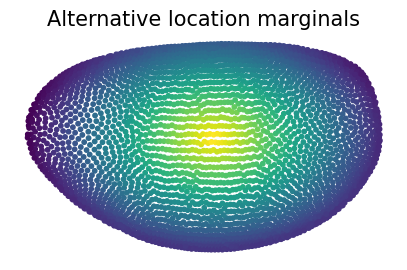

<Figure size 432x288 with 0 Axes>

In [109]:
# configure locations probability values
rdist = novosparc.gm.prob_dist_from_center(locations)
atlas.obs['Alternative location marginals'] = rdist

novosparc.pl.embedding(atlas, ['Alternative location marginals'])
# tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon, p_locations=rdist)

In [110]:
leiden_location = quantify_clusters_spatially(tissue)

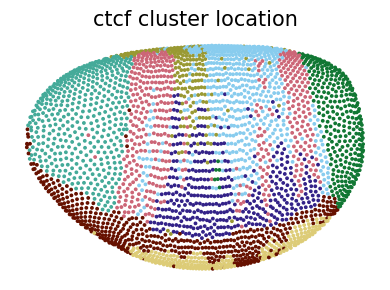

In [111]:
tit_size = 15
dpi = 100
fig, ax = plt.subplots(figsize=(4,3), dpi=dpi)

ax.scatter(locations_apriori[:, 0], locations_apriori[:, 1], c=leiden_location, cmap = my_colors, s=3)

ax.set_title('ctcf cluster location', size=tit_size)


ax.axis('off')



plt.tight_layout()
plt.show()

View of AnnData object with n_obs × n_vars = 4115 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'X_scvi_norm', 'X_scvi_raw', 'log1p', 'norm', 'norm_log_unscaled', 'raw', 'scvi_norm_log'
    obsp: 'connectivities', 'distances'

In [133]:
pl_genes = ['lncRNA:CR45693', 'lncRNA:CR45559', 'lncRNA:CR44317', 'lncRNA:43432']

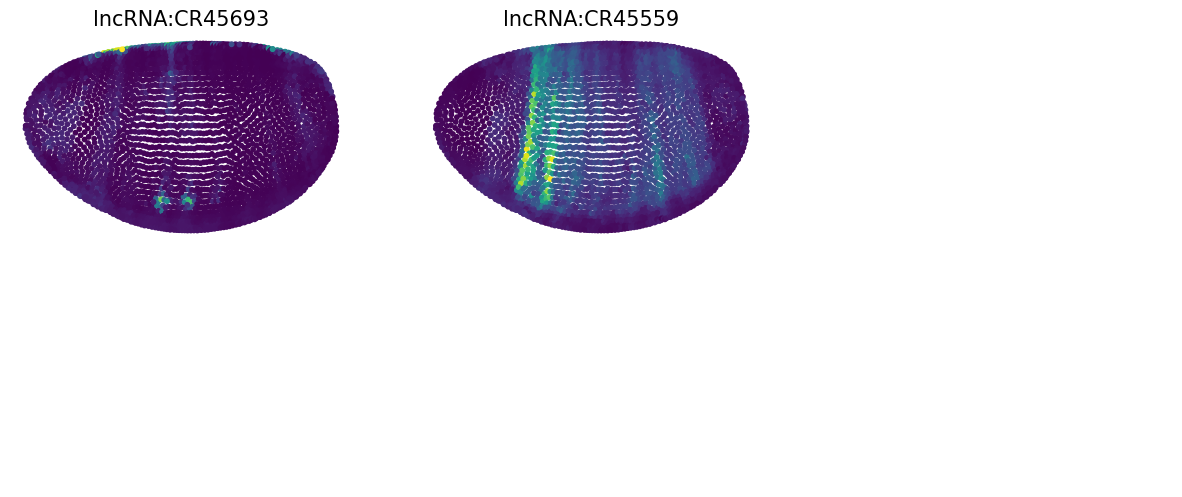

<Figure size 432x288 with 0 Axes>

In [134]:
# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

#title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes)

In [48]:
dataset_reconst.obs.index = dataset_reconst.obs.index.map(str)

In [49]:
dataset_reconst.obs = pd.merge(pd.DataFrame(dataset_reconst.obs), df, on = dataset_reconst.obs.index)


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [50]:
dataset_reconst

AnnData object with n_obs × n_vars = 3039 × 5999
    obs: 'key_0', 'cell 1', 'cell 12', 'archetype 0', 'archetype 1', 'archetype 2', 'archetype 3', 'archetype 4', 'archetype 5', 'archetype 6', 'archetype 7'
    obsm: 'spatial'

Finding gene archetypes ... done


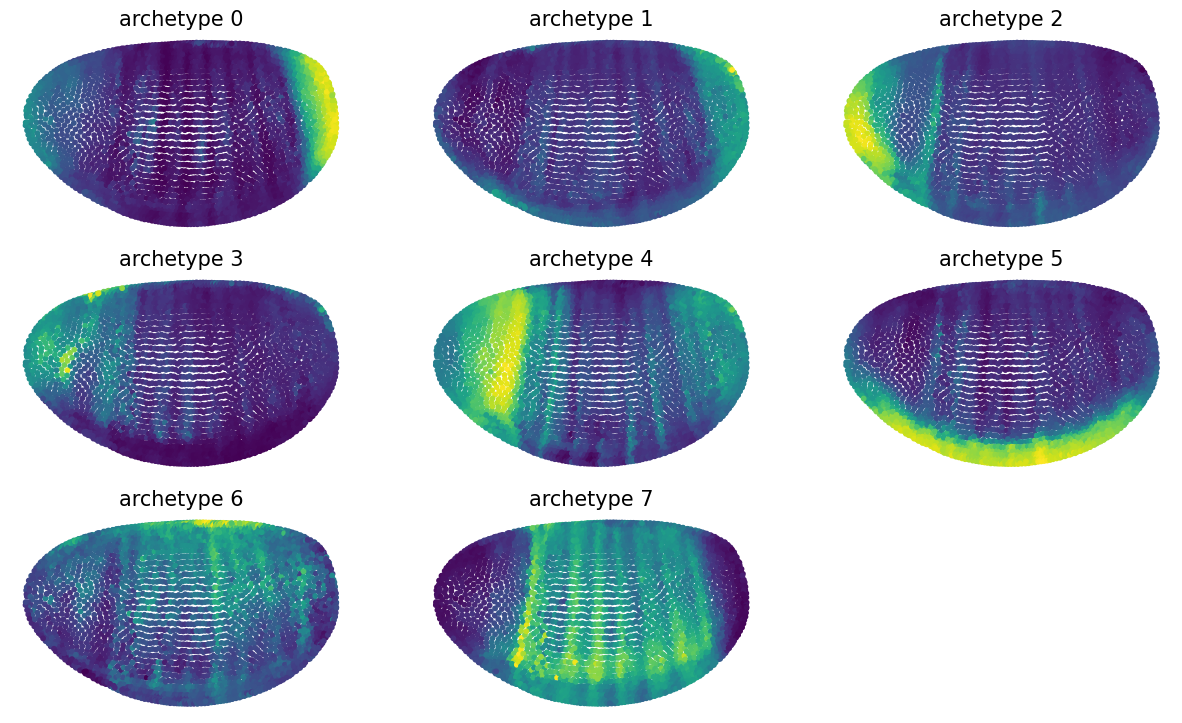

<Figure size 432x288 with 0 Axes>

In [51]:
# plot spatial expression archetypes
num_clusters = 8
atlas_indices = pd.DataFrame(np.arange(num_genes), index=gene_names)[0].loc[markers].values
archetypes, clusters, gene_corrs = novosparc.rc.find_spatial_archetypes(num_clusters, sdge[atlas_indices,:])

arch_cols = ['archetype %d'% i for i in np.arange(num_clusters)]
#dataset_reconst.obs = pd.DataFrame(index=dataset_reconst.obs.index)
df = pd.DataFrame(archetypes.T, columns=arch_cols)
#dataset_reconst.obs = pd.concat((dataset_reconst.obs, df), 1)

novosparc.pl.embedding(dataset_reconst, arch_cols)

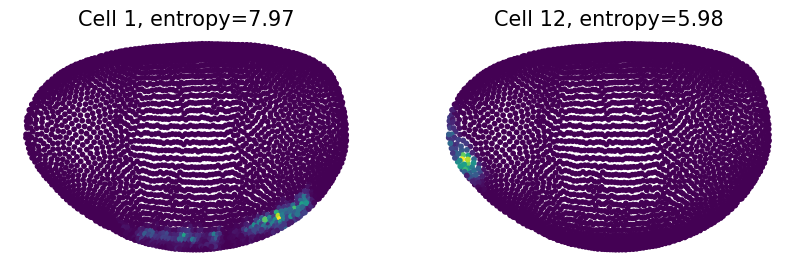

<Figure size 432x288 with 0 Axes>

In [45]:

# probability of individual cells belonging to each location
gw = tissue.gw
ngw = (gw.T / gw.sum(1)).T
cell_idx = [1, 12]
cell_prb_cols = ['cell %d' % i for i in cell_idx]
dataset_reconst.obs = pd.DataFrame(ngw.T[:, cell_idx], columns=cell_prb_cols)

title=['Cell %d, entropy=%.02f' % (i, novosparc.an.get_cell_entropy(ngw[i,:])) for i in cell_idx]
novosparc.pl.embedding(dataset_reconst, cell_prb_cols, title=title)

Reconstructing spatial information with 65 markers: 4115 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03


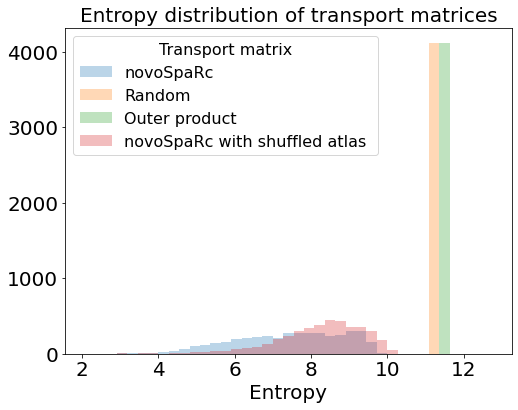

KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=0.2641555285540705, pvalue=1.3255266220191279e-126)


In [46]:

# comparing distributions of entropy for transporting a cell to locations
ent_T, ent_T_unif, ent_T_rproj, ent_T_shuf = novosparc.pl.plot_transport_entropy_dist(tissue)

print(ks_2samp(ent_T, ent_T_rproj))
print(ks_2samp(ent_T, ent_T_shuf))

In [305]:
DE_6only = pd.read_csv('DE_6only.csv')

In [306]:
genes_6 = list(DE_6only['gene'])